In [23]:
# !pip download iisignature

In [24]:
!pip install "/kaggle/working/iisignature-0.24.tar.gz"

Processing ./iisignature-0.24.tar.gz
  Preparing metadata (setup.py) ... done
  Created wheel for iisignature: filename=iisignature-0.24-cp310-cp310-linux_x86_64.whl size=1401821 sha256=71f8403457e63922690b4f247f8e4be9424343feb893967ec237e2b8b9486db3
  Stored in directory: /root/.cache/pip/wheels/74/af/00/ce1acdb847324bebf10d5a73d4f3b03dfc1bd1f560aa9cce16
Successfully built iisignature
  Attempting uninstall: iisignature
    Found existing installation: iisignature 0.24
    Uninstalling iisignature-0.24:
      Successfully uninstalled iisignature-0.24


In [25]:
import sys
sys.path.append('/kaggle/usr/lib')

import numpy as np
import pandas as pd
import os
import time
import h5py

import iisignature as isig
from basic_preprocessing_utility_script import process_as_h5, signature, get_eeg_sp_data

import matplotlib.pyplot as plt



iisignature is already installed.


In [26]:
# filename = '/kaggle/input/hms-harmful-brain-activity-classification/train.csv'
# process_as_h5(filename, num_examples = 1000)

In [27]:
hdf5_file = '/kaggle/working/hdf5/processed_dataset_1000.h5'
num_examples = 1000



with h5py.File(hdf5_file, 'r') as file:
    # List all groups
    
    print("Keys: %s" % file.keys())
    
    file_keys = list(file.keys())

    a_group_key = list(file.keys())[0]
    
    eeg_data = np.array(file[f"eeg"])
    sp_data = np.array(file[f"sp"])
    targets = np.array(file[f"targets"])
    num_votes = np.array(file[f"num_votes"])
    num_votes = num_votes.reshape((len(num_votes), -1))
    

Keys: <KeysViewHDF5 ['eeg', 'num_votes', 'sp', 'targets']>


## We try just using the EEG data

In [28]:
print(eeg_data.shape)
print(targets.shape)
print(sp_data.shape)

(1000, 2000, 18)
(1000, 6)
(1000, 4, 300, 100)


## We try applying the signature across each signal

### We apply the signature across the different streams (there are 4 of length 4, and then one 'other' of length 2)

In [29]:
eeg_streams = [eeg_data[:,:,:4],  eeg_data[:,:,4:8], eeg_data[:,:,8:12], eeg_data[:,:,12:16], eeg_data[:,:,16:]]
eeg_stream_sig = [signature(stream, level=4) for stream in eeg_streams]


In [30]:
for stream in eeg_stream_sig:
    print(stream.shape)

(1000, 340)
(1000, 340)
(1000, 340)
(1000, 340)
(1000, 30)


In [31]:
eeg_sig = np.concatenate(eeg_stream_sig, axis=-1)

print(eeg_sig.shape)

(1000, 1390)


Create historgram of values in eeg_sig to see in what range values in the signautre are in

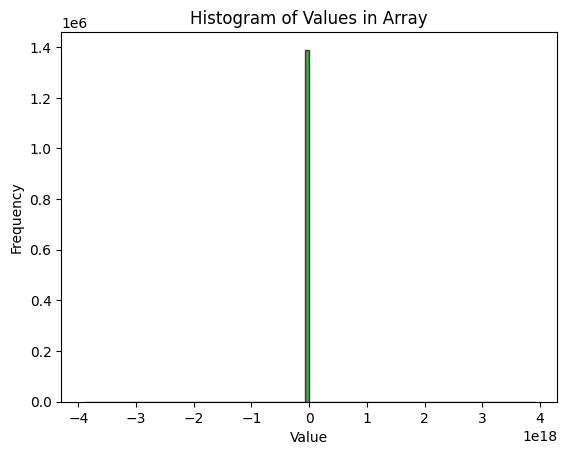

In [32]:
# Creating the histogram
import matplotlib.pyplot as plt

plt.hist(eeg_sig.reshape(-1), bins=100, alpha=0.7, color='green', edgecolor='black')

plt.title('Histogram of Values in Array')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Display the histogram
plt.show()

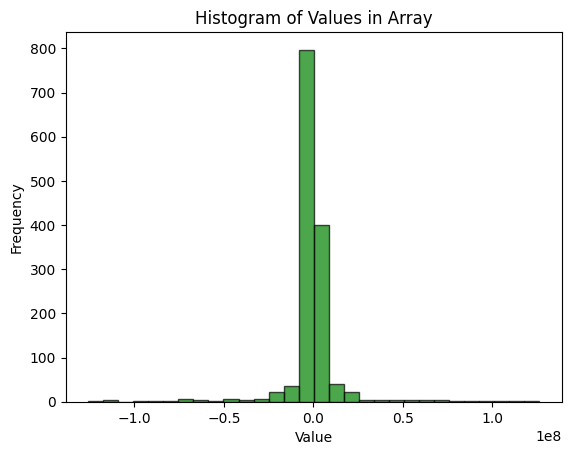

In [33]:
# Creating the histogram
plt.hist(eeg_sig[0], bins=30, alpha=0.7, color='green', edgecolor='black')

plt.title('Histogram of Values in Array')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Display the histogram
plt.show()

### We clip the output of the signature to be between -0.5 and 0.5

In [34]:
eeg_sig_clip = np.clip(eeg_sig, a_min=-0.5, a_max=0.5)

### Write the above preprocessing steps as a single function

In [35]:
def preprocess(pre_eeg):
    pre_eeg_streams = [pre_eeg[:,:,:4],  pre_eeg[:,:,4:8], pre_eeg[:,:,8:12],
                       pre_eeg[:,:,12:16], pre_eeg[:,:,16:]]
    
    pre_eeg_stream_sig = [signature(stream, level=4) for stream in pre_eeg_streams]
    pre_eeg_sig = np.concatenate(pre_eeg_stream_sig, axis=-1)
    pre_eeg_sig_clip = np.clip(pre_eeg_sig, a_min=-0.5, a_max=0.5)
    return pre_eeg_sig_clip
    
    

In [36]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split

# Mock data
features = eeg_sig_clip
targets = targets

# Convert to PyTorch tensors
features_tensor = torch.tensor(features, dtype=torch.float32)
targets_tensor = torch.tensor(targets, dtype=torch.float32)

# Create a TensorDataset
dataset = TensorDataset(features_tensor, targets_tensor)

# Split dataset into train and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)



import torch.nn as nn
import torch.nn.functional as F

class DeeperNN(nn.Module):
    def __init__(self):
        super(DeeperNN, self).__init__()
        self.fc1 = nn.Linear(1390, 1024)  # Increase the number of neurons
        self.bn1 = nn.BatchNorm1d(1024)   # Batch normalization
        self.dropout1 = nn.Dropout(0.5)   # Dropout
        
        self.fc2 = nn.Linear(1024, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.dropout2 = nn.Dropout(0.5)
        
        self.fc3 = nn.Linear(512, 256)
        self.bn3 = nn.BatchNorm1d(256)
        self.dropout3 = nn.Dropout(0.5)
        
        self.fc4 = nn.Linear(256, 128)
        self.bn4 = nn.BatchNorm1d(128)
        self.dropout4 = nn.Dropout(0.5)
        
        self.fc5 = nn.Linear(128, 6)     # Final layer remains the same

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout3(x)
        
        x = F.relu(self.bn4(self.fc4(x)))
        x = self.dropout4(x)
        
        x = self.fc5(x)
        return F.log_softmax(x, dim=1) # Ensure output sums to 1

# Initialize the model
model = DeeperNN()





In [37]:
import torch.optim as optim
import matplotlib.pyplot as plt

# Assume nn, model, train_loader, and test_loader are already defined

# Loss function and optimizer
criterion = nn.KLDivLoss(reduction='batchmean')
optimizer = optim.Adam(model.parameters(), lr=0.01)

losses = []  # List to store the average loss per epoch
test_losses = []  # List to store the average test loss per epoch

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_loss = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    losses.append(avg_loss)

    # Evaluate on test set
    model.eval()  # Set the model to evaluation mode
    total_test_loss = 0
    with torch.no_grad():  # Disable gradient calculation for evaluation
        for inputs, labels in test_loader:
            outputs = model(inputs)
            test_loss = criterion(outputs, labels)
            total_test_loss += test_loss.item()
    
    avg_test_loss = total_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    
    print(f"Epoch {epoch+1}, Training Loss: {avg_loss}, Test Loss: {avg_test_loss}")

Epoch 1, Training Loss: 0.9018634099226731, Test Loss: 1.1744000017642975
Epoch 2, Training Loss: 0.6393208022301013, Test Loss: 0.6397077888250351
Epoch 3, Training Loss: 0.5625410813551682, Test Loss: 0.5396019518375397
Epoch 4, Training Loss: 0.4351590619637416, Test Loss: 0.6447674706578255
Epoch 5, Training Loss: 0.39377851669604963, Test Loss: 0.557968407869339
Epoch 6, Training Loss: 0.38481931732251096, Test Loss: 0.41664162278175354
Epoch 7, Training Loss: 0.3339879856659816, Test Loss: 0.48208698630332947
Epoch 8, Training Loss: 0.3005295006128458, Test Loss: 0.4431217983365059
Epoch 9, Training Loss: 0.3131136756676894, Test Loss: 0.5569871738553047
Epoch 10, Training Loss: 0.2641361871590981, Test Loss: 0.46703828126192093
Epoch 11, Training Loss: 0.25298201120816743, Test Loss: 0.5515967160463333
Epoch 12, Training Loss: 0.21822706667276529, Test Loss: 0.4828756973147392
Epoch 13, Training Loss: 0.20279228801910693, Test Loss: 0.4892456606030464
Epoch 14, Training Loss: 0.

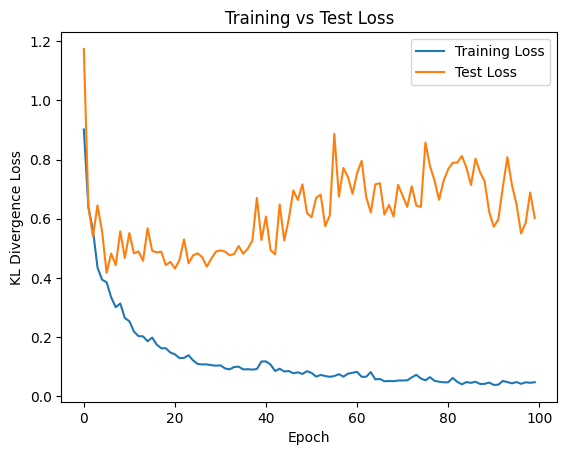

In [38]:


# Plotting
plt.plot(losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Training vs Test Loss')
plt.xlabel('Epoch')
plt.ylabel('KL Divergence Loss')
plt.legend()
plt.show()


## Try Submitting

In [39]:
test = pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/test.csv')
print('Test shape:',test.shape)


EEG_SUB_PATH_TEMPL = '/kaggle/input/hms-harmful-brain-activity-classification/test_eegs/'
SP_SUB_PATH_TEMPL = '/kaggle/input/hms-harmful-brain-activity-classification/test_spectrograms/'

test.head()

test.iloc[0]

Test shape: (1, 3)


spectrogram_id        853520
eeg_id            3911565283
patient_id              6885
Name: 0, dtype: int64

In [40]:
# Read all spectrograms
PATH = '/kaggle/input/hms-harmful-brain-activity-classification/test_spectrograms'
files = os.listdir(PATH)
print(f'There are {len(files)} test spectrogram parquets')
test_specs = {}
for i,f in enumerate(files):
    tmp = pd.read_parquet(f'{PATH}/{f}')
    name = int(f.split('.')[0])
    print(tmp)
    test_specs[name] = tmp.iloc[:,1:].values

There are 1 test spectrogram parquets
     time    LL_0.59    LL_0.78    LL_0.98  LL_1.17  LL_1.37  LL_1.56  \
0       1  14.910000  17.110001  11.660000    11.73     6.08     4.54   
1       3  11.130000  10.950000  10.770000     5.07     4.03     3.24   
2       5  10.880000  10.570000   8.790000     5.33     2.44     1.48   
3       7  19.450001  18.200001  17.719999    13.38     4.17     1.88   
4       9  21.650000  22.530001  23.160000    17.00     7.19     3.89   
..    ...        ...        ...        ...      ...      ...      ...   
295   591  15.580000  18.209999  14.020000    15.96     4.36     4.98   
296   593  17.209999  20.219999  20.889999    17.16     9.15     4.14   
297   595   9.610000  13.320000   9.190000    11.50     8.11     5.53   
298   597   8.430000  11.840000  13.640000    10.56     8.63     5.80   
299   599  12.330000  11.840000   9.420000     6.31     3.65     2.50   

     LL_1.76  LL_1.95  LL_2.15  ...  RP_18.16  RP_18.36  RP_18.55  RP_18.75  \
0     

In [41]:
print(test_specs[853520].shape)

(300, 400)


In [42]:
# def eeg_from_parquet(parquet_path, display=False):
    
#     # EXTRACT MIDDLE 50 SECONDS
#     eeg = pd.read_parquet(parquet_path, columns=FEATS)
#     rows = len(eeg)
#     offset = (rows-10_000)//2
#     eeg = eeg.iloc[offset:offset+10_000]
    
#     if display: 
#         plt.figure(figsize=(10,5))
#         offset = 0
    
#     # CONVERT TO NUMPY
#     data = np.zeros((10_000,len(FEATS)))
#     for j,col in enumerate(FEATS):
        
#         # FILL NAN
#         x = eeg[col].values.astype('float32')
#         m = np.nanmean(x)
#         if np.isnan(x).mean()<1: x = np.nan_to_num(x,nan=m)
#         else: x[:] = 0
            
#         data[:,j] = x
        
#         if display: 
#             if j!=0: offset += x.max()
#             plt.plot(range(10_000),x-offset,label=col)
#             offset -= x.min()
            
#     if display:
#         plt.legend()
#         name = parquet_path.split('/')[-1]
#         name = name.split('.')[0]
#         plt.title(f'EEG {name}',size=16)
#         plt.show()
        
#     return data

In [43]:
def get_sub_eeg_sp_data(train_row):
    """Gets EEG and Spectogram data from a specific row in the dataset"""
    
    eeg_id = train_row.eeg_id
    sp_id = train_row.spectrogram_id
    
    eeg_parquet = pd.read_parquet(f'{EEG_SUB_PATH_TEMPL}{eeg_id}.parquet')
    sp = pd.read_parquet(f'{SP_SUB_PATH_TEMPL}{sp_id}.parquet')
    
    rows = len(eeg_parquet)
    eeg_offset = (rows-10_000)//2
    
    
    # get middle 50 seconds of eeg data
    #eeg_offset = int(train_row.eeg_label_offset_seconds + 20) #only 10 central seconds from 50 secs were labeled, which should be seconds 20-30 in the sample
    eeg_data = eeg_parquet.iloc[eeg_offset:eeg_offset + 10_000]
    
    
    # sp_offset = int(train_row.spectrogram_label_offset_seconds )
    
    # get spectrogram data
    # sp = sp_parquet.loc[(sp_parquet.time>=sp_offset)&(sp_parquet.time<sp_offset+SP_WIN)]
    sp = sp.loc[:, sp.columns != 'time']
    sp = {
        "LL": sp.filter(regex='^LL', axis=1),
        "RL": sp.filter(regex='^RL', axis=1),
        "RP": sp.filter(regex='^RP', axis=1),
        "LP": sp.filter(regex='^LP', axis=1)}
    
    # calculate eeg data
    # print(eeg_data.keys()) # Has keys Index(['Fp1', 'F3', 'C3', 'P3', 'F7', 'T3', 'T5', 'O1', 'Fz', 'Cz', 'Pz',
                            # 'Fp2', 'F4', 'C4', 'P4', 'F8', 'T4', 'T6', 'O2', 'EKG']
    # assert 0 == 1
    
    CHAINS = {
    'LL' : [("Fp1","F7"),("F7","T3"),("T3","T5"),("T5","O1")],
    'RL' : [("Fp2","F8"),("F8","T4"),("T4","T6"),("T6","O2")],
    'LP' : [("Fp1","F3"),("F3","C3"),("C3","P3"),("P3","O1")],
    'RP' : [("Fp2","F4"),("F4","C4"),("C4","P4"),("P4","O2")],
    'other' : [("Fz","Cz"), ("Cz", "Pz"), ("EKG")]
}
    
    eeg = pd.DataFrame({})
    for chain in CHAINS.keys():
        for s_i, signals in enumerate(CHAINS[chain]):
            if len(signals) == 2:
                diff=eeg_data[signals[0]]-eeg_data[signals[1]] # Subtracts relevant fields as in the image above
                diff.ffill(inplace = True) # forward fills in the casse of nan values
                eeg[f"{chain}: {signals[0]} - {signals[1]}"] = diff
            
            elif len(signals) == 1:
                sig=eeg_data[signals[0]]
                sig.ffill(inplace = True) 
                eeg[f"{chain}: {signals[0]}"] = sig
                
                
    
    return eeg, sp

In [44]:
eeg_sub, sp_sub = get_sub_eeg_sp_data(test.iloc[0])

print(eeg_sub.shape)

(10000, 18)


In [45]:
sub = pd.DataFrame({'eeg_id':test.eeg_id.values})
sub

,eeg_id
0,3911565283


In [46]:
eeg_sub = np.expand_dims(eeg_sub, axis=0)

print(eeg_sub.shape)

(1, 10000, 18)


In [47]:
prep_eeg_sub = preprocess(eeg_sub)

In [48]:
print(prep_eeg_sub.shape)

(1, 1390)


In [49]:
model.eval()

sub_pred = model(torch.from_numpy(prep_eeg_sub).float()) # this gives the log of the probs

sub_pred = np.exp(sub_pred.detach().numpy())

print("This is the sub pred sum:",sub_pred.sum())
print(sub_pred)

This is the sub pred sum: 1.0000001
[[9.6388268e-01 9.4837049e-04 8.9074811e-03 3.6130869e-04 8.1316484e-03
  1.7768605e-02]]


In [50]:
# CREATE SUBMISSION.CSV
from IPython.display import display

TARGETS = ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
sub[TARGETS] = sub_pred
sub.to_csv('submission.csv',index=False)
print('Submission shape',sub.shape)
display( sub.head() )

# SANITY CHECK TO CONFIRM PREDICTIONS SUM TO ONE
print('Sub row 0 sums to:',sub.iloc[0,-6:].sum())

Submission shape (1, 7)


,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,3911565283,0.963883,0.000948,0.008907,0.000361,0.008132,0.017769


Sub row 0 sums to: 1.0000000980799086
